In [337]:
import os
import sys
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

In [325]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split, KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from scipy.sparse import csr_matrix, hstack

# Goal
Here we are looking at data from the 1994 census provided by the UCI ML Repository accessible [here](https://archive.ics.uci.edu/ml/index.php).  Unfortunately the income is discretized to only being greater or less than 50K USD.  We will go through all the categorical and numeric features to see if any should be dropped or engineered then choose the best model using cross validation.  After, we will do a grid-search CV in order to optimize our hyperparameters.

# Bring in Data

In [212]:
cwd = os.getcwd()
df = pd.read_csv(os.path.join(cwd, "data", "adult.data"),
                 skipinitialspace=True,
                 names=["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"])
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [213]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [214]:
df = df.fillna(np.nan)

In [215]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

About 75% of the people involved in the census make below 50K

In [216]:
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})
df.income.value_counts()

0    24720
1     7841
Name: income, dtype: int64

In [217]:
numeric_features = ['age','fnlwgt','education-num','capital-gain',
                    'capital-loss','hours-per-week','income']
cat_features = ['workclass', 'education', 'marital-status', 'occupation',
                'relationship', 'race', 'sex', 'native-country']

# Numeric Features

Hours per week, age, and education are most correlated to the income

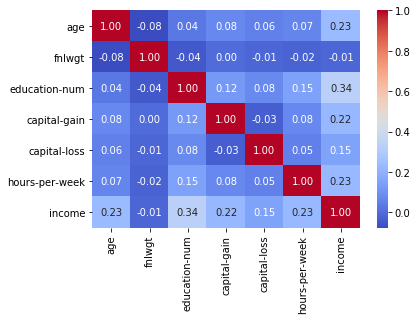

In [149]:
sns.heatmap(df[numeric_features].corr(), 
                  fmt=".2f", annot=True, cmap="coolwarm")

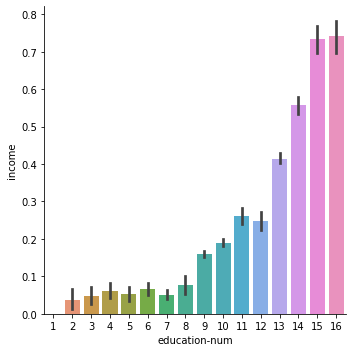

In [182]:
sns.catplot(x="education-num", y="income", data=df, kind="bar")

Less than 50K right skewed while people making more than 50K seem to have a nice bell curve with an average age of a little more than 40  

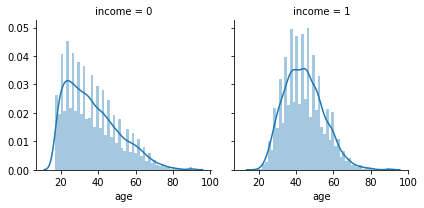

In [151]:
sns.FacetGrid(df, col='income').map(sns.distplot, "age")

# Categorical Features

Only explicit change to the categorical features is that we set marital status to be binary: married or single.  Also, after inspecting the native country feature it should probably be dropped - large variance there

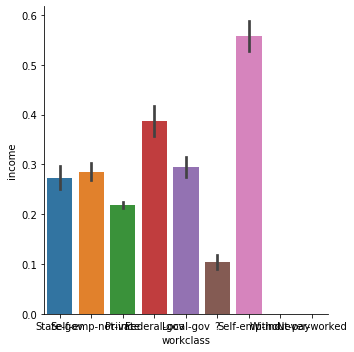

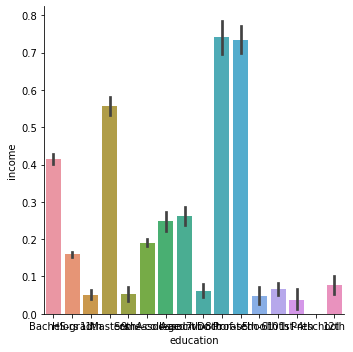

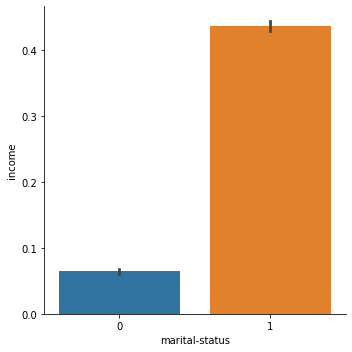

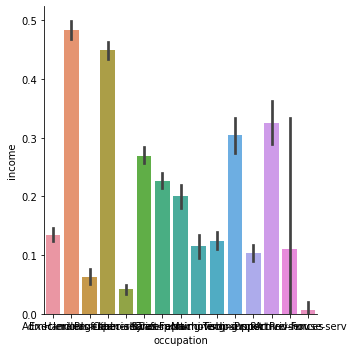

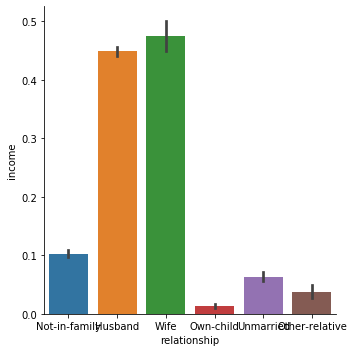

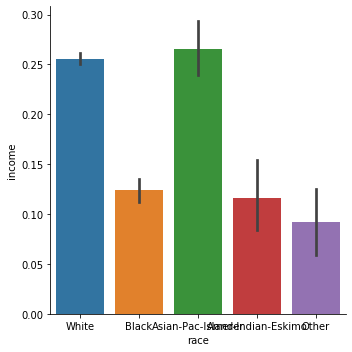

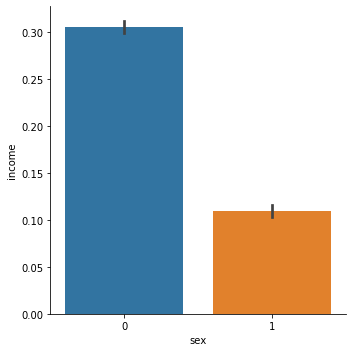

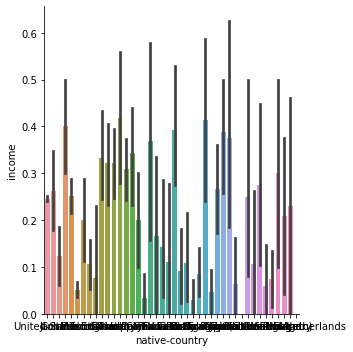

In [181]:
for cat in cat_features:
    sns.catplot(x=cat, y="income", data=df, kind="bar")

# Feature Engineering

In [218]:
df["marital-status"] = df["marital-status"].replace(['Never-married',
                                                     'Divorced','Separated','Widowed'],
                                                    'Single')
df["marital-status"] = df["marital-status"].replace(['Married-civ-spouse',
                                                     'Married-spouse-absent','Married-AF-spouse'],
                                                    'Married')
df = df.drop(['native-country'], axis=1)
cat_features.remove('native-country')

Encode categorical features with only two values as a binary encoder, and use dummy variables / OHE for others

In [219]:
le = LabelEncoder()
dummy_columns = []

for cat in cat_features:
    if df[cat].nunique() == 2:
        df[cat] = le.fit_transform(df[cat]) 
    else:
        dummy_columns.append(cat)
        
#apply get dummies for selected columns
df = pd.get_dummies(data=df, columns=dummy_columns)
df.head()

,age,fnlwgt,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,income,workclass_?,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,39,77516,13,1,1,2174,0,40,0,0,...,1,0,0,0,0,0,0,0,0,1
1,50,83311,13,0,1,0,0,13,0,0,...,0,0,0,0,0,0,0,0,0,1
2,38,215646,9,1,1,0,0,40,0,0,...,1,0,0,0,0,0,0,0,0,1
3,53,234721,7,0,1,0,0,40,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,0,0,40,0,0,...,0,0,0,0,1,0,0,1,0,0


In [224]:
df.columns

Index(['age', 'fnlwgt', 'education-num', 'marital-status', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'income',
       'workclass_?', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'education_10th', 'education_11th',
       'education_12th', 'education_1st-4th', 'education_5th-6th',
       'education_7th-8th', 'education_9th', 'education_Assoc-acdm',
       'education_Assoc-voc', 'education_Bachelors', 'education_Doctorate',
       'education_HS-grad', 'education_Masters', 'education_Preschool',
       'education_Prof-school', 'education_Some-college', 'occupation_?',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct'

# Modeling: Choose Best Model

In [259]:
X = df.drop(['income'], axis=1).values
y = df.income.values

In [260]:
print(X)

[[    39  77516     13 ...      0      0      1]
 [    50  83311     13 ...      0      0      1]
 [    38 215646      9 ...      0      0      1]
 ...
 [    58 151910      9 ...      0      0      1]
 [    22 201490      9 ...      0      0      1]
 [    52 287927      9 ...      0      0      1]]


In [261]:
# params 
test_size = 0.20
seed = 347
num_folds = 10
scoring = 'accuracy'

num_trees = 100

models = [('LR', LogisticRegression()),
          ('LDA', LinearDiscriminantAnalysis()),
          ('KNN', KNeighborsClassifier()),
          ('DT', DecisionTreeClassifier()),
          ('NB', GaussianNB()),
          ('RF', RandomForestClassifier())]

csr_supp = ['LR']

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size, random_state=seed)

X_train_csr = csr_matrix(X_train)

In [277]:
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    if name in csr_supp:
        cv_results = cross_val_score(model, 
                                 X_train_csr, y_train, cv=kfold, scoring=scoring)
    else:
        cv_results = cross_val_score(model, 
                                 X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{:3s}: {:.4f} ({:.6f})'.format(name, cv_results.mean(), cv_results.std()))

LR : 0.7959 (0.006817)
LDA: 0.8401 (0.008576)
KNN: 0.7722 (0.007889)
DT : 0.8113 (0.009626)
NB : 0.7924 (0.005856)
RF : 0.8460 (0.005644)


In [278]:
print(np.shape(results))
results[0]

(6, 10)


array([0.79654511, 0.80537428, 0.7915547 , 0.78925144, 0.79309021,
       0.80307102, 0.80191939, 0.7815739 , 0.79800307, 0.7983871 ])

Random Forest is the winner here - highest mean accuracy during cross-validation and the folds have lower variance than the second best algorithm, LDA. 

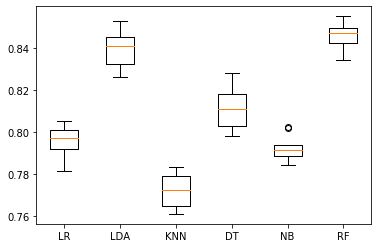

In [282]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Modeling: Grid Search Best Model
Now lets optimize the estimators and features of the RF though a grid-search CV

In [290]:
n_estimators = np.linspace(50, 250, num=5, dtype=int)
max_features = np.linspace(1, 7, num=7, dtype=int)
param_grid = dict(n_estimators=n_estimators, max_features=max_features)

model = RandomForestClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

In [310]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.853348 using {'max_features': 7, 'n_estimators': 200}


In [315]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%.4f (%.6f): %r" % (mean, stdev, param))

0.8428 (0.005824): {'max_features': 1, 'n_estimators': 50}
0.8432 (0.005624): {'max_features': 1, 'n_estimators': 100}
0.8434 (0.005622): {'max_features': 1, 'n_estimators': 150}
0.8435 (0.006079): {'max_features': 1, 'n_estimators': 200}
0.8444 (0.005199): {'max_features': 1, 'n_estimators': 250}
0.8449 (0.005351): {'max_features': 2, 'n_estimators': 50}
0.8473 (0.005149): {'max_features': 2, 'n_estimators': 100}
0.8467 (0.005355): {'max_features': 2, 'n_estimators': 150}
0.8448 (0.005304): {'max_features': 2, 'n_estimators': 200}
0.8468 (0.005431): {'max_features': 2, 'n_estimators': 250}
0.8487 (0.005054): {'max_features': 3, 'n_estimators': 50}
0.8494 (0.005793): {'max_features': 3, 'n_estimators': 100}
0.8479 (0.005819): {'max_features': 3, 'n_estimators': 150}
0.8489 (0.004883): {'max_features': 3, 'n_estimators': 200}
0.8500 (0.005111): {'max_features': 3, 'n_estimators': 250}
0.8485 (0.005539): {'max_features': 4, 'n_estimators': 50}
0.8501 (0.006803): {'max_features': 4, 'n_es

# Results

In [317]:
random_forest = RandomForestClassifier(**grid_result.best_params_)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)

Significantly lower precision and recall for people with incomes greater than 50K.  It would be nice to have a regression here, but we can still assume the people that do make greater than 50K are close to the cutoff.

In [323]:
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, predictions)))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.8589
[[4599  346]
 [ 573  995]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4945
           1       0.74      0.63      0.68      1568

    accuracy                           0.86      6513
   macro avg       0.82      0.78      0.80      6513
weighted avg       0.85      0.86      0.85      6513



In [327]:
pkl.dump(random_forest, open(os.path.join(cwd, "data", "RFmodel.pkl"), "wb"))

In [336]:
def makePrediction(X):
    model = pkl.load(open(os.path.join(cwd, "data", "RFmodel.pkl"), "rb"))
    return model.predict(X.reshape(1,len(X)))
print(makePrediction(X_test[31]))

[1]
